In [419]:
import os
import urllib, cStringIO

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import tabular as tb
import pandas as pd
import json
import re

from PIL import Image
import base64

from helpers import *

__Notes from analysis 6/18/17:__

Six complete games to analyze.

Not super strong reduction in svg length across epochs (though there does appear to be something for draw duration).

Replication of closer vs. further effect.

Accuracy very high (at ceiling for further trials). But tried to analyze error trials, to see whether sketchers compensated by adding more detail on the next rep of that object, and there does seem to be evidence for that, but there were so few error trials...

One possibility moving forward is to drop the further trials altogether, and focus on the closer trials, where there is more pressure to conventionalize/simplify since drawings are starting out more verbose. 

An additional possibility is to increase the set size for each trial, maybe up to 8 objects. Is there reason to think that set size decreases p(conventionalization)? 

-- other thoughts: maybe not enough __uncertainty, set size, time constraints, familiar vs. novel objects, similarity between exemplars ... __

-- __too many filler trials__ lop off the further trials, 6 reps, and use the other 3 closer rows of 4 objects to add 12 filler trials.

-- look at same object in early round across pairs

-- try running the sketchpad version with tangrams?

-- oh, and maybe viewer real-time __feedback__ during sketching... like, a recognition buzzer for the viewer. 

In [312]:
# directory & file hierarchy
analysis_dir = '/Users/judithfan/reference_games/analysis/3dObjects/sketchpad_repeated'
data_dir = '/Users/judithfan/reference_games/data/3dObjects/sketchpad_repeated'
exp_dir = '/Users/judithfan/reference_games/experiments/3dObjects/sketchpad_repeated'

In [124]:
import pymongo as pm
conn = pm.MongoClient(port=27017)
db = conn['3dObjects']
coll = db['sketchpad_repeated']

In [125]:
S = coll.find({ '$and': [{'expid':'pilot2'}, {'dataType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'expid':'pilot2'}, {'dataType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

1190 stroke records in the database.
175 clickedObj records in the database.


In [54]:
# remember to filter out test records that 
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV']
unique_gameids = coll.find({ '$and': [{'expid':'pilot2'}, {'dataType': 'clickedObj'}]}).sort('time').distinct('gameid')
print map(str,unique_gameids)

['3132-f3e52817-8077-48b5-bb6e-76b8f34bbe3b', '0621-d8ddacd3-5173-4b1f-9cbd-003e0323b4c8', '0747-aa69bdf2-6b19-413a-a5f3-43bf65645a5e', '3462-0bdc5ad9-844a-42e7-b11a-d2f7e52e1d1f', '4341-7077986e-13c1-4022-a169-e6406fde06fd']


In [37]:
S = coll.find({ '$and': [{'shiftKeyUsed':0}, {'dataType': 'stroke'}]}).sort('time')
print S.count()

1876


In [324]:
workers = [i for i in coll.find({'expid':'pilot2'}).distinct('workerId') if i not in jefan]

In [335]:
gameid = []
valid_gameids = []

# pilot 1
mg = coll.find({'expid': 'pilot'}).distinct('gameid')
for g in mg:
    gameid.append(g) # append gameids from 'pilot' (the first one) 
# pilot 2
workers = [i for i in coll.find({'expid':'pilot2'}).distinct('workerId') if i not in jefan]
for w in workers:
    gameid.append(coll.find({ '$and': [{'expid':'pilot2'}, {'workerId': w}]}).distinct('gameid')[0]) ## add from pilot2    
# pilot 3
mg =  coll.find({'expid': 'pilot3'}).distinct('gameid') # add from 'pilot3' (the second one)   
for g in mg:
    gameid.append(g)
    
gameids = np.unique(gameid)
for i,g in enumerate(gameids):
    W = coll.find({ '$and': [{'gameid': g}]}).distinct('workerId')
    for w in W:
        X = coll.find({ '$and': [{'workerId': w}, {'gameid': g}]}).distinct('trialNum')
        dataType = coll.find({ '$and': [{'workerId': w}]}).distinct('dataType')
        print i, w[:4], len(X), str(dataType[0])
        if (str(dataType[0])=='clickedObj') & (len(X)==56):
            valid_gameids.append(g)
print '   ===========   '
print str(len(valid_gameids)) + ' valid gameIDs.'

0 A194 13 clickedObj
1 AHGQ 56 stroke
1 A33F 56 clickedObj
2 AVD6 7 stroke
2 A3JT 6 clickedObj
3 A1CU 56 clickedObj
4 ACSS 56 stroke
4 A5NH 56 clickedObj
5 AMDP 56 stroke
5 ATMQ 56 clickedObj
6 AGRK 56 stroke
6 A3O5 56 clickedObj
7 A38D 56 stroke
7 A2WT 56 clickedObj
8 A39Q 1 stroke
9  3 clickedObj
6 valid gameIDs.


In [104]:
g = valid_gameids[0]


In [336]:
import re
S = coll.find({ '$and': [{'gameid': g}, {'dataType': 'stroke'}]}).sort('time')
for s in S:
    string = s['svgStr']
    num_curves = len([m.start() for m in re.finditer('c', string)])
#     print num_curves

In [337]:
TrialNum = []
GameID = []
Condition = []
Target = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Epoch = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = []
Repeated = []

for g in valid_gameids:
    print 'Analyzing game: ', g

    X = coll.find({ '$and': [{'gameid': g}, {'dataType': 'clickedObj'}]}).sort('time')
    Y = coll.find({ '$and': [{'gameid': g}, {'dataType': 'stroke'}]}).sort('time')

    for t in X:
        targetname = t['intendedName']
        Epoch.append(t['epoch'])
    #     distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
    #     full_list = [t['intendedTarget'],t['object2Name'],t['object3Name'],t['object4Name']] 
        y = coll.find({ '$and': [{'gameid': g}, {'dataType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
        ns = y.count()
        numStrokes.append(ns)
        drawDuration.append((y.__getitem__(ns-1)['time'] - y.__getitem__(0)['time'])/1000) # in seconds
    #     svgs = Y[Y['trialNum']==t['trialNum']]['svg']
        ls = [len(_y['svgStr']) for _y in y]
        svgStringLength.append(reduce(lambda x, y: x + y, ls))
        y = coll.find({ '$and': [{'gameid': g}, {'dataType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
        num_curves = [len([m.start() for m in re.finditer('c', _y['svgStr'])]) for _y in y]
        numCurvesPerSketch.append(reduce(lambda x, y: x + y, num_curves))
        numCurvesPerStroke.append(reduce(lambda x, y: x + y, num_curves)/ns)
        svgStringLengthPerStroke.append(reduce(lambda x, y: x + y, ls)/ns)
        svgStringStd.append(np.std(ls))
    #     ## aggregate game metadata
        TrialNum.append(t['trialNum'])
        GameID.append(t['gameid'])        
        Target.append(targetname)
        Condition.append(t['condition'])
        Response.append(t['clickedName'])
        Outcome.append(t['correct'])
        Repeated.append(t['repeated'])
    #     Distractor1.append(distractors[0])
    #     Distractor2.append(distractors[1])
    #     Distractor3.append(distractors[2])  
    



Analyzing game:  0621-d8ddacd3-5173-4b1f-9cbd-003e0323b4c8
Analyzing game:  1017-a0229889-00a4-4179-b678-8851674813c2
Analyzing game:  2118-d675a95d-2f17-4f6d-93b7-6872be616d06
Analyzing game:  3462-0bdc5ad9-844a-42e7-b11a-d2f7e52e1d1f
Analyzing game:  4341-7077986e-13c1-4022-a169-e6406fde06fd
Analyzing game:  4407-009a1477-465e-4460-b85d-daccb62b4574


In [338]:
GameID,TrialNum,Condition, Target, Epoch, Repeated, drawDuration, Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd = map(np.array, \
[GameID,TrialNum,Condition, Target, Epoch, Repeated, drawDuration,Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd])    

Epoch = map(int,Epoch)

D = tb.tabarray(columns = [GameID,TrialNum,Condition, Target, Epoch, Repeated, drawDuration,Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd],
                names = ['gameID','trialNum','condition', 'target', 'epoch', 'repeated', 'drawDuration','outcome', 'response', 'numStrokes', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd'])

In [339]:
# get summary statistics
all_games = np.unique(D['gameID'])
further_strokes = []
closer_strokes = []
further_svgLength = []
closer_svgLength = []
further_svgStd = []
closer_svgStd = []
further_svgLengthPS = []
closer_svgLengthPS = []
further_drawDuration = []
closer_drawDuration = []
further_accuracy = []
closer_accuracy = []
for game in all_games:    
    further_strokes.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['numStrokes'].mean())
    closer_strokes.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['numStrokes'].mean())
    further_svgLength.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['svgStringLength'].mean())
    closer_svgLength.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['svgStringLength'].mean())
    further_svgStd.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['svgStringStd'].mean())
    closer_svgStd.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['svgStringStd'].mean())    
    further_svgLengthPS.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['svgStringLengthPerStroke'].mean())
    closer_svgLengthPS.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['svgStringLengthPerStroke'].mean())
    further_drawDuration.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['drawDuration'].mean())
    closer_drawDuration.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['drawDuration'].mean())
    further_accuracy.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['outcome'].mean())
    closer_accuracy.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['outcome'].mean())
    
further_strokes, closer_strokes, further_svgLength, closer_svgLength, \
further_svgStd, closer_svgStd, further_svgLengthPS, closer_svgLengthPS, \
further_drawDuration, closer_drawDuration, further_accuracy, closer_accuracy = map(np.array, \
[further_strokes, closer_strokes, further_svgLength, closer_svgLength,\
 further_svgStd, closer_svgStd, further_svgLengthPS, closer_svgLengthPS, \
further_drawDuration, closer_drawDuration, further_accuracy, closer_accuracy])

In [340]:
print further_strokes.mean(), closer_strokes.mean()
print further_svgLength.mean(), closer_svgLength.mean()
print further_svgStd.mean(), closer_svgStd.mean()
print further_svgLengthPS.mean(), closer_svgLengthPS.mean()
print further_drawDuration.mean(), closer_drawDuration.mean()
print further_accuracy.mean(), closer_accuracy.mean()

6.18452380952 8.72619047619
1179.30357143 2139.39880952
179.620810393 293.945887223
238.864076547 285.128159007
11.8277440476 24.8179404762
0.982142857143 0.886904761905


Saving figure to 'plots/svg_summary_scatter.pdf'... Done


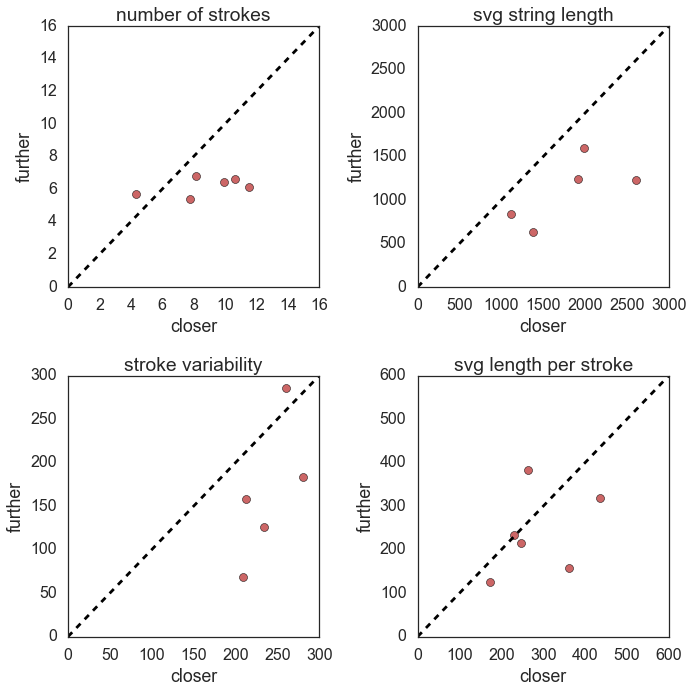

In [356]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_strokes,further_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgLength,further_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgStd,further_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,4)
lb = 0
ub = 600
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgLengthPS,further_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('closer')
plt.ylabel('further')
save_out = 1
if save_out:
    helpers.save('plots/svg_summary_scatter', ext='pdf', close=False, verbose=True)

Saving figure to 'plots/performance_summary_scatter.pdf'... Done


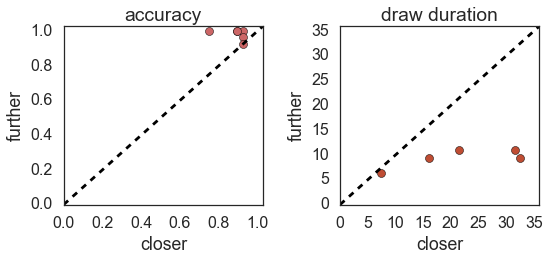

In [342]:
fig = plt.figure(figsize=(8,4))
lb = 0
ub = 1.03
plt.subplot(1,2,1)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_accuracy,further_accuracy,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('accuracy')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(1,2,2)
lb = 0
ub = 36
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_drawDuration,further_drawDuration,64,(0.75,0.3,0.2))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('draw duration')
plt.xlabel('closer')
plt.ylabel('further')
plt.tight_layout()
save_out = 1
if save_out:
    helpers.save('plots/performance_summary_scatter', ext='pdf', close=False, verbose=True)

In [343]:
# convert D to pandas dataframe
D = pd.DataFrame(D)

# combine information about repeated and distance conditions into trialType
trialType = []
for g in zip(D['repeated'],D['condition']):
    trialType.append(g[0] + '_' + g[1])
D = D.assign(trialType=pd.Series(trialType).values)

# add png to D dataframe
png = []
for g in valid_gameids:
    X = coll.find({ '$and': [{'gameid': g}, {'dataType': 'clickedObj'}]}).sort('time')
    Y = coll.find({ '$and': [{'gameid': g}, {'dataType': 'stroke'}]}).sort('time')
    # print out sketches from all trials from this game
    for t in X: 
        png.append(t['pngString'])
D = D.assign(png=pd.Series(png).values)

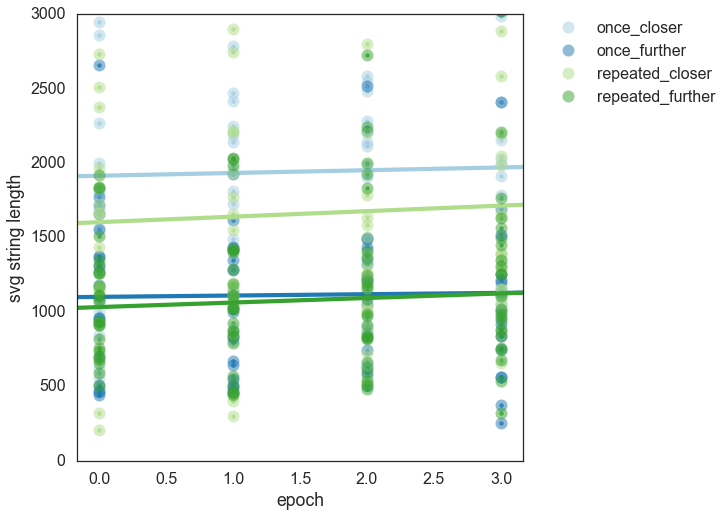

In [360]:
# plot relationship between accuracy and activations
labels = D['trialType']
colors = sns.color_palette("Paired",n_colors=4)
color_dict = dict(zip(list(np.unique(labels)),colors))
df = pd.DataFrame(dict(x=D['epoch'], y=D['svgStringLength'], label=labels))
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(8,8))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name, alpha=0.5,color=color_dict[name])    
    ax = sns.regplot(group.x, group.y,robust=True, ci=None, marker='o',color=color_dict[name])      
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([0,3000])
plt.xlabel('epoch')
plt.ylabel('svg string length')
plt.title('')
save('plots/svg_string_length_by_epoch','png',close=False,verbose=False)
plt.show()

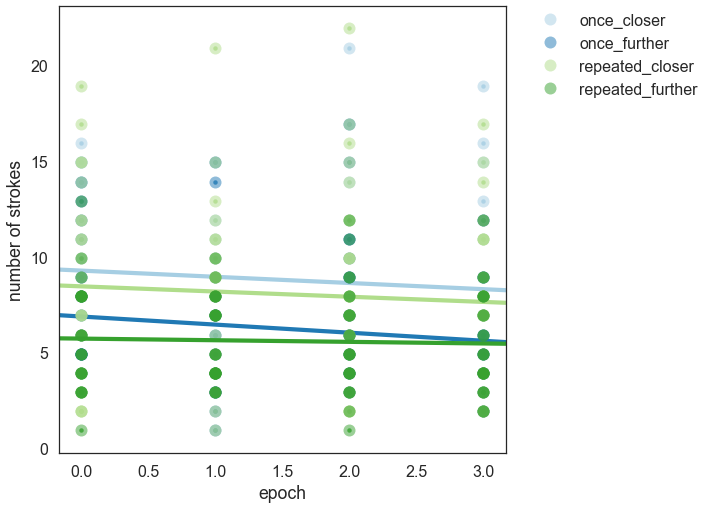

In [347]:
# plot relationship between accuracy and activations
labels = D['trialType']
colors = sns.color_palette("Paired",n_colors=4)
color_dict = dict(zip(list(np.unique(labels)),colors))
df = pd.DataFrame(dict(x=D['epoch'], y=D['numStrokes'], label=labels))
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(8,8))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name, alpha=0.5,color=color_dict[name])    
    ax = sns.regplot(group.x, group.y,robust=True, ci=None, marker='o',color=color_dict[name])      
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('epoch')
plt.ylabel('number of strokes')
plt.title('')
save('plots/number_strokes_by_epoch','png',close=False,verbose=False)
plt.show()

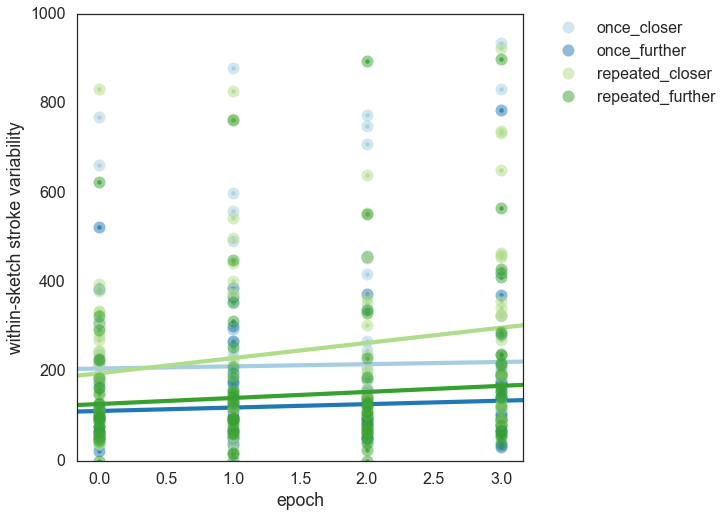

In [359]:
# plot relationship between accuracy and activations
labels = D['trialType']
colors = sns.color_palette("Paired",n_colors=4)
color_dict = dict(zip(list(np.unique(labels)),colors))
df = pd.DataFrame(dict(x=D['epoch'], y=D['svgStringStd'], label=labels))
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(8,8))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name, alpha=0.5,color=color_dict[name])    
    ax = sns.regplot(group.x, group.y,robust=True, ci=None, marker='o',color=color_dict[name])      
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([0,1000])
plt.xlabel('epoch')
plt.ylabel('within-sketch stroke variability')
plt.title('')
save('plots/stroke_variability_by_epoch','png',close=False,verbose=False)
plt.show()

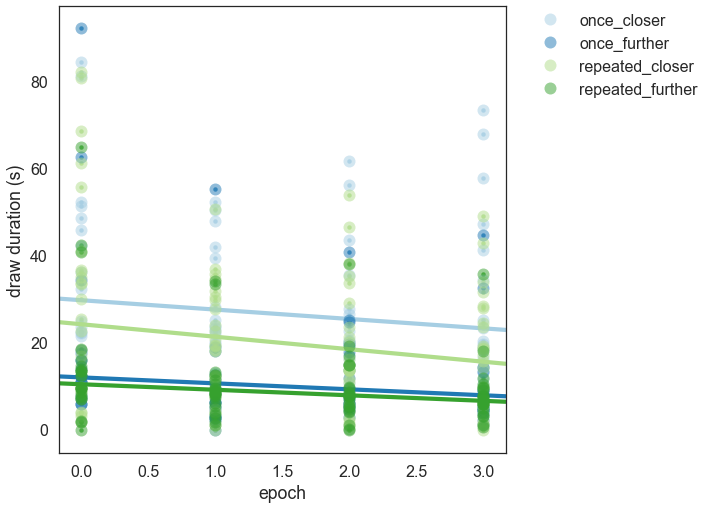

In [354]:
# plot relationship between accuracy and activations
labels = D['trialType']
colors = sns.color_palette("Paired",n_colors=4)
color_dict = dict(zip(list(np.unique(labels)),colors))
df = pd.DataFrame(dict(x=D['epoch'], y=D['drawDuration'], label=labels))
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(8,8))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name, alpha=0.5,color=color_dict[name])    
    ax = sns.regplot(group.x, group.y,robust=True, ci=None, marker='o',color=color_dict[name])      
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('epoch')
plt.ylabel('draw duration (s)')
plt.title('')
save('plots/draw_duration_by_epoch','png',close=False,verbose=False)
plt.show()

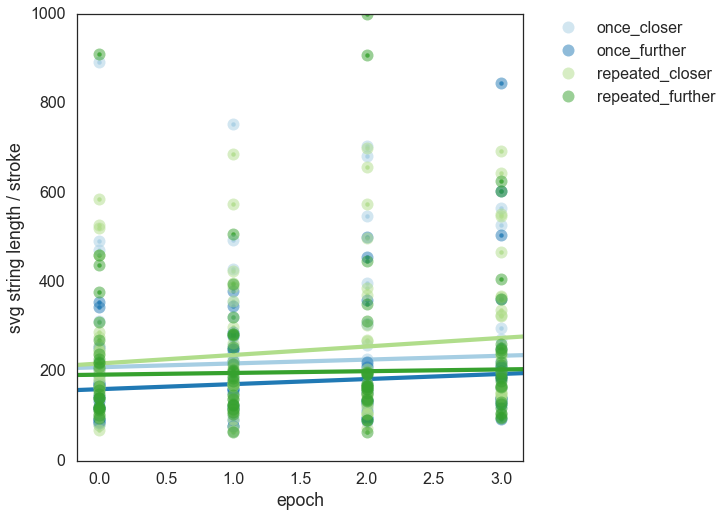

In [358]:
# plot relationship between accuracy and activations
labels = D['trialType']
colors = sns.color_palette("Paired",n_colors=4)
color_dict = dict(zip(list(np.unique(labels)),colors))
df = pd.DataFrame(dict(x=D['epoch'], y=D['svgStringLengthPerStroke'], label=labels))
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(8,8))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name, alpha=0.5,color=color_dict[name])    
    ax = sns.regplot(group.x, group.y,robust=True, ci=None, marker='o',color=color_dict[name])      
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([0,1000])
plt.xlabel('epoch')
plt.ylabel('svg string length / stroke')
plt.title('')
save('plots/string_length_per_stroke_by_epoch','png',close=False,verbose=False)
plt.show()

In [362]:
### for g in valid_gameids:
for g in valid_gameids:
    print 'Printing out sketches from game: ' + g
    trial_types = ['repeated_closer','repeated_further','once_closer','once_further']
    for tt in trial_types:
        _D = D[(D.trialType==tt) & (D.gameID==g)]
        _D = _D.sort_values(by=['epoch','target'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(8,8))
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(4,4,_i)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)             
            if (_i < 5) & (tt in ['repeated_closer','repeated_further']):
                plt.title(_d['target'] ,fontsize=textsize)
            elif tt not in ['repeated_closer','repeated_further']:
                plt.title(_d['target'] ,fontsize=textsize)
            if (_i-1)%4==0:
                plt.ylabel('epoch ' + str(_d['epoch']) ,fontsize=textsize)
            _i  = _i + 1
        sketch_dir = os.path.join(analysis_dir,'sketches')
        filepath = os.path.join(sketch_dir,'gameID_' + _d['gameID'] + '_type_' + _d['trialType'])
        helpers.save(filepath, ext='pdf', close=True, verbose=False)


Printing out sketches from game: 0621-d8ddacd3-5173-4b1f-9cbd-003e0323b4c8
Printing out sketches from game: 1017-a0229889-00a4-4179-b678-8851674813c2
Printing out sketches from game: 2118-d675a95d-2f17-4f6d-93b7-6872be616d06
Printing out sketches from game: 3462-0bdc5ad9-844a-42e7-b11a-d2f7e52e1d1f
Printing out sketches from game: 4341-7077986e-13c1-4022-a169-e6406fde06fd
Printing out sketches from game: 4407-009a1477-465e-4460-b85d-daccb62b4574


1

In [ ]:
####

Number of miss trials (before last epoch): 9
Number of hit trials (before last epoch): 135


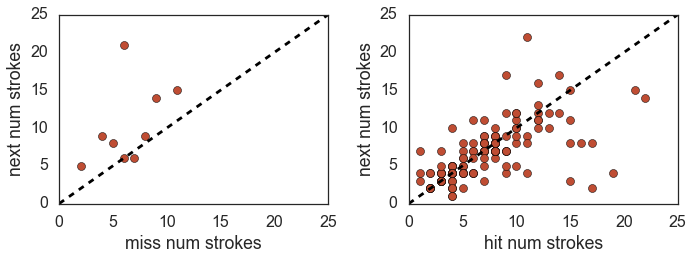

In [418]:
##### Question: If viewer didn't guess the target THIS epoch, did sketcher expend more strokes
##### the next time?

### for g in valid_gameids:
miss_strokes = []
next_strokes = []

hit_strokes = []
hit_next_strokes = []

for g in valid_gameids:
    trial_types = ['repeated_closer','repeated_further','once_closer','once_further']
    for tt in trial_types:
        _D = D[(D.trialType==tt) & (D.gameID==g)]
        _D = _D.sort_values(by=['epoch','target'])
        for i,_d in _D.iterrows():
            if (_d['outcome']==0) & (_d['epoch']<3) & (_d['repeated']=='repeated'): 
                __D = D[(D.trialType==tt) & (D.gameID==g) & (D.epoch==_d['epoch']+1) & (D.target==_d['target'])]
                miss_strokes.append(_d['numStrokes'])
                next_strokes.append(__D['numStrokes'].values[0])  
            elif (_d['outcome']==1) & (_d['epoch']<3) & (_d['repeated']=='repeated'):
                __D = D[(D.trialType==tt) & (D.gameID==g) & (D.epoch==_d['epoch']+1) & (D.target==_d['target'])]
                hit_strokes.append(_d['numStrokes'])
                hit_next_strokes.append(__D['numStrokes'].values[0])
miss_strokes, next_strokes, hit_strokes, hit_next_strokes = map(np.array,[miss_strokes, next_strokes, hit_strokes, hit_next_strokes])
print 'Number of miss trials (before last epoch): ' + str(len(miss_strokes))
print 'Number of hit trials (before last epoch): ' + str(len(hit_strokes))

lb = 0
ub = 25
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(miss_strokes,next_strokes,64,(0.75,0.3,0.2))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.xlabel('miss num strokes')
plt.ylabel('next num strokes')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(hit_strokes,hit_next_strokes,64,(0.75,0.3,0.2))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.xlabel('hit num strokes')
plt.ylabel('next num strokes')
plt.tight_layout()